In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from mech import Mech, move
from parts import Param, Part, Solid, Base, Joint, Slider, Point, round_vector
from runners import Runner1D

In [2]:
def draw_model(model, end_position = False):
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')    
    cm = plt.get_cmap('tab20')
    colors = cm(np.linspace(0, 1, 20))
    for i, part in enumerate(model.parts.values()):
        if not isinstance(part, Joint) and not part.name == 'base':
            points = list(part.points.values())
            first_segment = True
            for p1, p2 in zip(points[:-1], points[1:]):
                x = [p1.absolute[0], p2.absolute[0]]
                y = [p1.absolute[1], p2.absolute[1]]
                label = part.name if first_segment and end_position else None
                plt.plot(x, y, color=colors[i], label= label)
                first_segment = False
    if end_position:
        plt.legend()        
    


In [3]:
def draw_trace(model, trace, columns):
    df = pd.DataFrame(trace)
    part_names = [k for k in model.parts.keys()]
    cm = plt.get_cmap('tab20')
    colors = cm(np.linspace(0, 1, 20))    
    for col in columns:
        part_name = col.split('.')[0]
        part_index = part_names.index(part_name)
        tr = pd.DataFrame(df[col].tolist(), columns=['x', 'y'])
        plt.scatter(tr.x, tr.y, color=colors[part_index])

In [4]:
def plot_forces(trace, cols=None):

    tr = pd.DataFrame(trace)
    forces = {'t': tr.t.values}
    
    if cols is None:
        cols = [c[:-2] for c in tr.columns if c.split('.')[-1] == 'F']
    
    for col in cols:
        cn = col.split('.')
        point_name = f"{cn[0]}.{cn[1]}"
        force = pd.DataFrame(tr[col+'.F'].tolist(), columns=['x', 'y'])
        forces[point_name] = np.sqrt(force.x ** 2 + force.y ** 2) 
            
    forces = pd.DataFrame(forces).set_index('t')
    for col in forces.columns:
        plt.plot(forces.index.values, forces[col].values, label=col)
    plt.legend()

In [5]:
def pt(point_name):
    point_loc = eval(point_name)
    if len(point_loc) < 3:
        point_loc += [point_name]
    yaml_array = f"[{point_loc[0]}, {point_loc[1]}, {point_loc[2]}]"
    return yaml_array


In [6]:
def distance(v1, v2):
    return np.sqrt((v2[0] - v1[0]) ** 2 + (v2[1] - v1[1]) ** 2)

In [7]:
def elongation(v1, v2, extra_length):
    diff = np.array([v2[0] - v1[0], v2[1] - v1[1]])
    norm = distance(v1, v2)
    direction = diff / norm
    end = np.array([v2[0], v2[1]]) + direction * extra_length
    return [end[0], end[1]]

In [8]:
L = 1 #np.sqrt(2) / 2

txt = f"""
parts:
    lever1:
        type: solid
        points:
            - [0, 0, 'fixed']
            - [0, {L}, 'j1']
    slider1:
        type: slider
        points:
            - [1, 0, 'fixed']
            - [1, {L}, 'j1']
run:
    - ['slider1', 0.5, 1.5]"""

import yaml
yaml.load(txt, yaml.Loader)

{'parts': {'lever1': {'type': 'solid',
   'points': [[0, 0, 'fixed'], [0, 1, 'j1']]},
  'slider1': {'type': 'slider', 'points': [[1, 0, 'fixed'], [1, 1, 'j1']]}},
 'run': [['slider1', 0.5, 1.5]]}

In [9]:
model2, motion2 = Mech.from_yaml(txt)
print(model2)

Base 'base':
    point '0': [0 0] -> [0 0], F=[0. 0.]
    point '1': [1 0] -> [1 0], F=[0. 0.]
Solid 'lever1': angle=[0. 1.], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[0. 0.]
    point '1': [0 1] -> [0. 1.], F=[0. 0.]
Slider 'slider1': angle=[0. 1.], v=[0. 0.]
    point '0': [1 0] -> [1 0], F=[0. 0.]
    point '1': [1 1] -> [1 1], F=[0. 0.]
Joint 'base0': energy=0.0
    'base.0': [0 0] -> [0 0], F=[0. 0.]
    'lever1.0': [0 0] -> [0 0], F=[0. 0.]
Joint 'j1': energy=1.0
    'lever1.1': [0 1] -> [0 1], F=[0. 0.]
    'slider1.1': [1 1] -> [1 1], F=[0. 0.]
Joint 'base1': energy=0
    'base.1': [1 0] -> [1 0], F=[0. 0.]
    'slider1.0': [1 0] -> [1 0], F=[0. 0.]


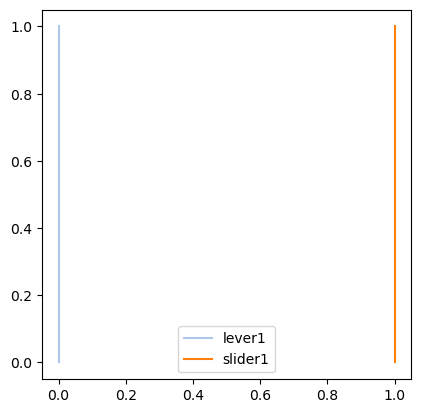

In [10]:
draw_model(model2, end_position=True)

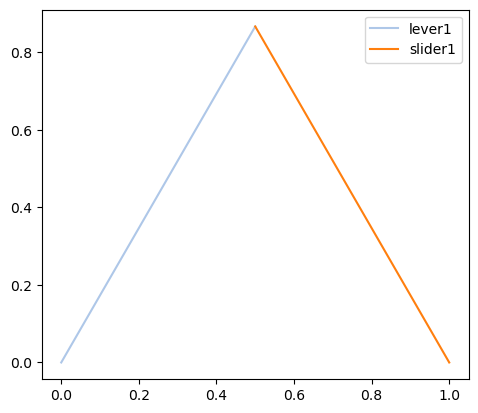

In [11]:
model2.solve()
draw_model(model2, end_position=True)

In [12]:
model2.charge(ext_moments = {'lever1': 1.0})
model2

Base 'base':
    point '0': [0 0] -> [0 0], F=[0. 0.]
    point '1': [1 0] -> [1 0], F=[0. 0.]
Solid 'lever1': angle=[-0.5    0.866], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[ 0.5773 -1.    ]
    point '1': [0 1] -> [0.5   0.866], F=[-0.5773  1.    ]
Slider 'slider1': angle=[0.5   0.866], v=[ 0.134 -0.5  ]
    point '0': [1 0] -> [1. 0.], F=[-0.5773  1.    ]
    point '1': [1. 1.] -> [0.5   0.866], F=[ 0.5773 -1.    ]
Joint 'base0': energy=0.0
    'base.0': [0 0] -> [0 0], F=[0. 0.]
    'lever1.0': [0 0] -> [0 0], F=[ 0.5773 -1.    ]
Joint 'j1': energy=0.0
    'lever1.1': [0 1] -> [0 1], F=[-0.5773  1.    ]
    'slider1.1': [1. 1.] -> [1. 1.], F=[ 0.5773 -1.    ]
Joint 'base1': energy=0.0
    'base.1': [1 0] -> [1 0], F=[0. 0.]
    'slider1.0': [1 0] -> [1 0], F=[-0.5773  1.    ]

In [13]:
model2.force_points_index

[    point '0': [0 0] -> [0. 0.], F=[ 0.5773 -1.    ],
     point '1': [0 1] -> [0.5   0.866], F=[-0.5773  1.    ],
     point '1': [1. 1.] -> [0.5   0.866], F=[ 0.5773 -1.    ],
     point '0': [1 0] -> [1. 0.], F=[-0.5773  1.    ]]

In [14]:
model2.force_points

{'lever1': {'0': 0, '1': 1}, 'slider1': {'1': 2, '0': 3}}

In [15]:
model2.force_points

{'lever1': {'0': 0, '1': 1}, 'slider1': {'1': 2, '0': 3}}

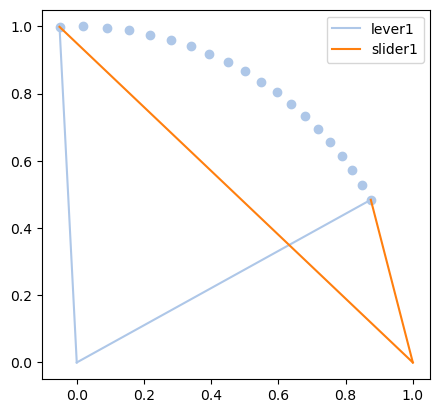

In [16]:
runner2 = Runner1D(model2, 
                      motion=motion2,
                      tracing_points=['lever1.1'],
                      moments=lambda t: {'lever1': 1.0},
                      draw_model=draw_model,
                      draw_trace=draw_trace
                     )

runner2.run()

In [17]:
pd.DataFrame(runner2.trace)

,t,base.0,base.1,lever1.0,lever1.0.F,lever1.1,lever1.1.F,slider1.length,slider1.0,slider1.0.F,slider1.1,slider1.1.F,base0,j1,base1
0,0.50,"[0, 0]","[1, 0]","[-0.0, 0.0]","[0.2582, -1.0]","[0.875, 0.4841]","[-0.2582, 1.0]",0.50,"[1.0, -0.0]","[-0.2582, 1.0]","[0.875, 0.4841]","[0.2582, -1.0]",True,True,True
1,0.55,"[0, 0]","[1, 0]","[-0.0, 0.0]","[0.286, -1.0]","[0.8488, 0.5288]","[-0.286, 1.0]",0.55,"[1.0, -0.0]","[-0.286, 1.0]","[0.8487, 0.5288]","[0.286, -1.0]",True,True,True
2,0.60,"[0, 0]","[1, 0]","[-0.0, 0.0]","[0.3145, -1.0]","[0.82, 0.5724]","[-0.3145, 1.0]",0.60,"[1.0, -0.0]","[-0.3145, 1.0]","[0.82, 0.5724]","[0.3145, -1.0]",True,True,True
3,0.65,"[0, 0]","[1, 0]","[0.0, 0.0]","[0.3437, -1.0]","[0.7888, 0.6147]","[-0.3437, 1.0]",0.65,"[1.0, -0.0]","[-0.3437, 1.0]","[0.7888, 0.6147]","[0.3437, -1.0]",True,True,True
4,0.70,"[0, 0]","[1, 0]","[0.0, 0.0]","[0.3736, -1.0]","[0.755, 0.6557]","[-0.3736, 1.0]",0.70,"[1.0, -0.0]","[-0.3736, 1.0]","[0.755, 0.6557]","[0.3736, -1.0]",True,True,True
5,0.75,"[0, 0]","[1, 0]","[-0.0, 0.0]","[0.4045, -1.0]","[0.7188, 0.6953]","[-0.4045, 1.0]",0.75,"[1.0, -0.0]","[-0.4045, 1.0]","[0.7188, 0.6953]","[0.4045, -1.0]",True,True,True
6,0.80,"[0, 0]","[1, 0]","[-0.0, -0.0]","[0.4364, -1.0]","[0.68, 0.7332]","[-0.4364, 1.0]",0.80,"[1.0, 0.0]","[-0.4364, 1.0]","[0.68, 0.7332]","[0.4364, -1.0]",True,True,True
7,0.85,"[0, 0]","[1, 0]","[-0.0, -0.0]","[0.4695, -1.0]","[0.6388, 0.7694]","[-0.4695, 1.0]",0.85,"[1.0, -0.0]","[-0.4695, 1.0]","[0.6388, 0.7694]","[0.4695, -1.0]",True,True,True
8,0.90,"[0, 0]","[1, 0]","[0.0, 0.0]","[0.5039, -1.0]","[0.595, 0.8037]","[-0.5039, 1.0]",0.90,"[1.0, 0.0]","[-0.5039, 1.0]","[0.595, 0.8037]","[0.5039, -1.0]",True,True,True
9,0.95,"[0, 0]","[1, 0]","[-0.0, 0.0]","[0.5398, -1.0]","[0.5488, 0.836]","[-0.5398, 1.0]",0.95,"[1.0, 0.0]","[-0.5398, 1.0]","[0.5488, 0.836]","[0.5398, -1.0]",True,True,True


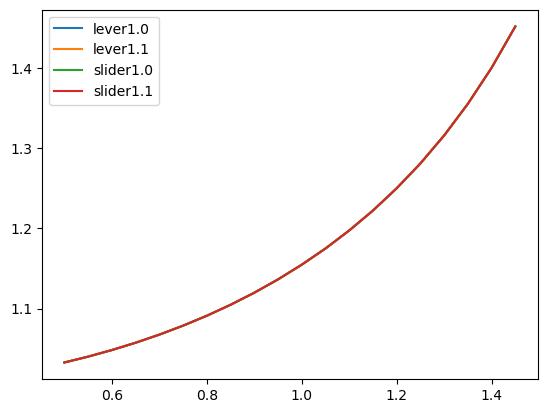

In [18]:
plot_forces(runner2.trace)    

In [37]:
wall_beg = [0, 0, 'fixed']
wall_end = [0.90, 0, 'fixed']

door_spindle = [0, 0, 'fixed']
door_console = [-0.25, -0.05]
door_end = [-0.80, 0]
door_beg = [0, 0]

outer_lever_to_door = door_console
outer_lever_spindle = [0, -0.40]
outer_lever_end = elongation(outer_lever_to_door, outer_lever_spindle, 0.10)

inner_lever_to_wall = [0.25, -0.05, 'fixed']
inner_lever_spindle = outer_lever_spindle

slider_to_wall = [0.75, -0.10, 'fixed']
slider_to_outer_lever = outer_lever_end

min_slider_len = distance(slider_to_wall, slider_to_outer_lever)
max_slider_len = min_slider_len + 0.25

print(min_slider_len, max_slider_len)

greenhouse = f"""
parts:
    wall:
        type: solid
        points:
            - {pt('wall_beg')}
            - {pt('wall_end')}
    door:
        type: solid
        points:
            - {pt('door_spindle')}
            - {pt('door_console')}
            - {pt('door_end')}
    outer_lever:
        type: solid
        points:
            - {pt('outer_lever_to_door')}
            - {pt('outer_lever_spindle')}
            - {pt('outer_lever_end')}
    inner_lever:
        type: solid
        points:
            - {pt('inner_lever_to_wall')}
            - {pt('outer_lever_spindle')}
    slider:
        type: slider
        points:
            - {pt('slider_to_wall')}
            - {pt('outer_lever_end')}
run: [
    ['slider', {min_slider_len}, {max_slider_len}, 10]
]
"""

0.7900242269794894 1.0400242269794893


In [38]:
model3, motion3 = Mech.from_yaml(greenhouse)
print(model3)
print(motion3)
print(model3.input_params)

Base 'base':
    point '0': [0 0] -> [0 0], F=[0. 0.]
    point '1': [0.9 0. ] -> [0.9 0. ], F=[0. 0.]
    point '2': [0 0] -> [0 0], F=[0. 0.]
    point '3': [ 0.25 -0.05] -> [ 0.25 -0.05], F=[0. 0.]
    point '4': [ 0.75 -0.1 ] -> [ 0.75 -0.1 ], F=[0. 0.]
Solid 'wall': angle=[0. 1.], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[0. 0.]
    point '1': [0.9 0. ] -> [0.9 0. ], F=[0. 0.]
Solid 'door': angle=[0. 1.], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[0. 0.]
    point '1': [-0.25 -0.05] -> [-0.25 -0.05], F=[0. 0.]
    point '2': [-0.8  0. ] -> [-0.8  0. ], F=[0. 0.]
Solid 'outer_lever': angle=[0. 1.], v=[0. 0.]
    point '0': [-0.25 -0.05] -> [-0.25 -0.05], F=[0. 0.]
    point '1': [ 0.  -0.4] -> [ 0.  -0.4], F=[0. 0.]
    point '2': [ 0.0581 -0.4814] -> [ 0.0581 -0.4814], F=[0. 0.]
Solid 'inner_lever': angle=[0. 1.], v=[0. 0.]
    point '0': [ 0.25 -0.05] -> [ 0.25 -0.05], F=[0. 0.]
    point '1': [ 0.  -0.4] -> [ 0.  -0.4], F=[0. 0.]
Slider 'slider': angle=[0. 1.], v=[0. 0.]


In [39]:
model3.charge(ext_moments = {'door': 1})
model3

Base 'base':
    point '0': [0 0] -> [0 0], F=[0. 0.]
    point '1': [0.9 0. ] -> [0.9 0. ], F=[0. 0.]
    point '2': [0 0] -> [0 0], F=[0. 0.]
    point '3': [ 0.25 -0.05] -> [ 0.25 -0.05], F=[0. 0.]
    point '4': [ 0.75 -0.1 ] -> [ 0.75 -0.1 ], F=[0. 0.]
Solid 'wall': angle=[0. 1.], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[0. 0.]
    point '1': [0.9 0. ] -> [0.9 0. ], F=[0. 0.]
Solid 'door': angle=[0. 1.], v=[0. 0.]
    point '0': [0 0] -> [0. 0.], F=[-0.8308  3.8338]
    point '1': [-0.25 -0.05] -> [-0.25 -0.05], F=[ 0.8308 -3.8338]
    point '2': [-0.8  0. ] -> [-0.8  0. ], F=[0. 0.]
Solid 'outer_lever': angle=[0. 1.], v=[0. 0.]
    point '0': [-0.25 -0.05] -> [-0.25 -0.05], F=[-0.8308  3.8338]
    point '1': [ 0.  -0.4] -> [ 0.  -0.4], F=[-5.0564 -7.079 ]
    point '2': [ 0.0581 -0.4814] -> [ 0.0581 -0.4814], F=[5.8872 3.2451]
Solid 'inner_lever': angle=[0. 1.], v=[0. 0.]
    point '0': [ 0.25 -0.05] -> [ 0.25 -0.05], F=[-5.0564 -7.079 ]
    point '1': [ 0.  -0.4] -> [ 0.  -

In [40]:
model3.A.shape

(22, 22)

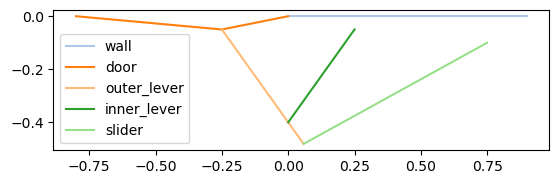

In [41]:
draw_model(model3, end_position=True)

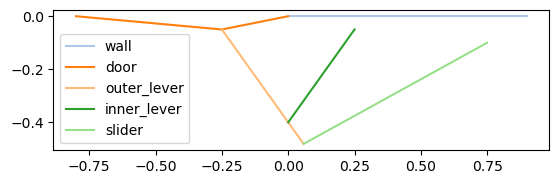

In [42]:
model3.solve()
draw_model(model3, end_position=True)

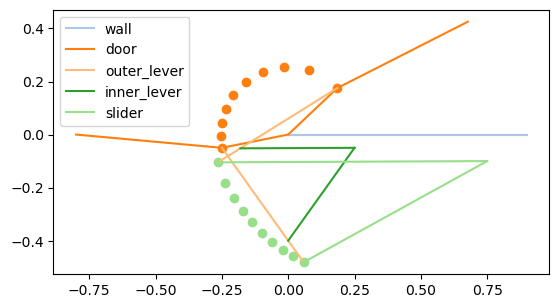

In [43]:
runner3 = Runner1D(model3, 
                      motion=motion3,
                      tracing_points=['door.1', 'slider.1'],
                      moments=lambda t: {'door': 0.1},
                      draw_model=draw_model,
                      draw_trace=draw_trace
                     )

runner3.run()

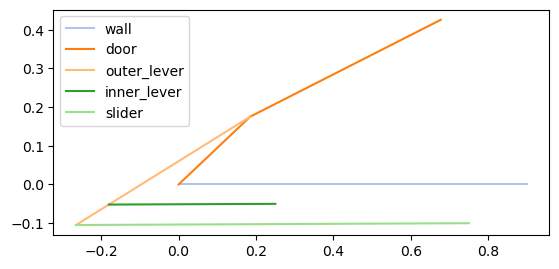

In [44]:
draw_model(model3, end_position=True)

In [45]:
pd.DataFrame(runner3.trace)

,t,base.0,base.1,base.2,base.3,base.4,wall.0,wall.0.F,wall.1,wall.1.F,...,slider.1,slider.1.F,base0,base1,base2,door_console,outer_lever_spindle,outer_lever_end,base3,base4
0,0.790024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[0.0, 0.0]","[0.0, 0.0]","[0.9, 0.0]","[0.0, 0.0]",...,"[0.0581, -0.4814]","[-0.5887, -0.3245]",True,True,True,True,True,True,True,True
1,0.815024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, -0.0]","[-0.0, 0.0]","[0.9, -0.0]","[0.0, -0.0]",...,"[0.0186, -0.4596]","[-0.6629, -0.3259]",True,True,True,True,True,True,True,True
2,0.840024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[0.0, -0.0]","[0.0, 0.0]","[0.9, -0.0]","[0.0, 0.0]",...,"[-0.0209, -0.4336]","[-0.7495, -0.3244]",True,True,True,True,True,True,True,True
3,0.865024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, -0.0]","[0.0, 0.0]","[0.9, -0.0]","[0.0, 0.0]",...,"[-0.06, -0.4036]","[-0.8483, -0.318]",True,True,True,True,True,True,True,True
4,0.890024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, -0.0]","[0.0, 0.0]","[0.9, -0.0]","[0.0, 0.0]",...,"[-0.0983, -0.3694]","[-0.9579, -0.3042]",True,True,True,True,True,True,True,True
5,0.915024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, -0.0]","[0.0, 0.0]","[0.9, -0.0]","[0.0, 0.0]",...,"[-0.1353, -0.3312]","[-1.0762, -0.2811]",True,True,True,True,True,True,True,True
6,0.940024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[0.0, -0.0]","[0.0, 0.0]","[0.9, -0.0]","[0.0, 0.0]",...,"[-0.1709, -0.2887]","[-1.2081, -0.2476]",True,True,True,True,True,True,True,True
7,0.965024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[0.0, -0.0]","[-0.0, 0.0]","[0.9, -0.0]","[0.0, -0.0]",...,"[-0.2047, -0.2406]","[-1.3773, -0.2029]",True,True,True,True,True,True,True,True
8,0.990024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, 0.0]","[0.0, 0.0]","[0.9, 0.0]","[0.0, 0.0]",...,"[-0.2365, -0.1832]","[-1.6627, -0.1403]",True,True,True,True,True,True,True,True
9,1.015024,"[0, 0]","[0.9, 0.0]","[0, 0]","[0.25, -0.05]","[0.75, -0.1]","[-0.0, 0.0]","[0.0, 0.0]","[0.9, 0.0]","[0.0, 0.0]",...,"[-0.265, -0.1047]","[-2.4672, -0.0114]",True,True,True,True,True,True,True,True


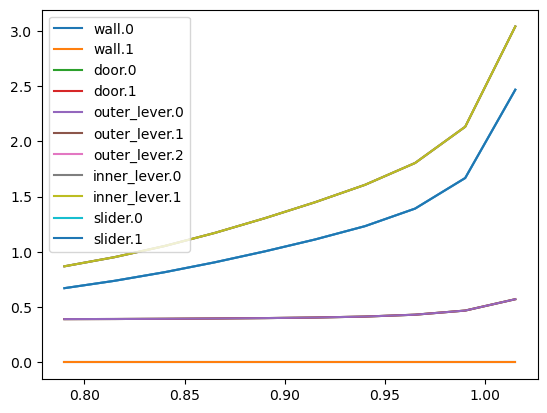

In [46]:
plot_forces(runner3.trace)

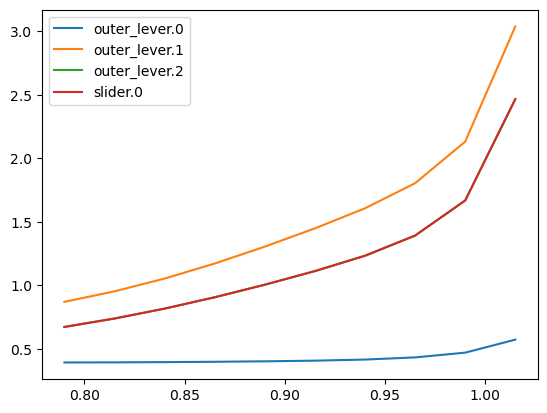

In [47]:
plot_forces(runner3.trace, ['outer_lever.0', 'outer_lever.1', 'outer_lever.2', 'slider.0'])

In [110]:
wall_beg = [0, 0, 'fixed']
wall_end = [0.90, 0, 'fixed']

door_spindle = [0, 0, 'fixed']
door_console = [-25 * p + 1, -5]
door_end = [-80, 0]
door_beg = [0, 0]

outer_lever_to_door = door_console
outer_lever_spindle = [0, -40 * p]
outer_lever_end = elongation(outer_lever_to_door, outer_lever_spindle, 5)

inner_lever_to_wall = [25 * p - 1, -5, 'fixed']
inner_lever_spindle = outer_lever_spindle

slider_to_wall = [75 * p + 20, -10, 'fixed']
slider_to_outer_lever = outer_lever_end

min_slider_len = distance(slider_to_wall, slider_to_outer_lever)
max_slider_len = min_slider_len + 10

print(min_slider_len, max_slider_len)

greenhouse = f"""
parts:
    wall:
        type: solid
        points:
            - {pt('wall_beg')}
            - {pt('wall_end')}
    door:
        type: solid
        points:
            - {pt('door_spindle')}
            - {pt('door_console')}
            - {pt('door_end')}
            - {pt('door_beg')}
    outer_lever:
        type: solid
        points:
            - {pt('outer_lever_to_door')}
            - {pt('outer_lever_spindle')}
            - {pt('outer_lever_end')}
    inner_lever:
        type: solid
        points:
            - {pt('inner_lever_to_wall')}
            - {pt('outer_lever_spindle')}
    slider:
        type: slider
        points:
            - {pt('slider_to_wall')}
            - {pt('outer_lever_end')}
run: [
    ['slider', {min_slider_len}, {max_slider_len}, 10]
]
"""

model4, motion4 = Mech.from_yaml(greenhouse)



47.86249620343226 57.86249620343226


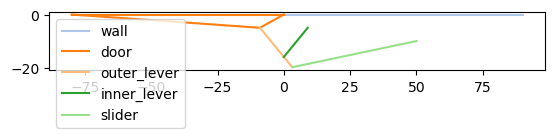

In [111]:
draw_model(model4, end_position=True)

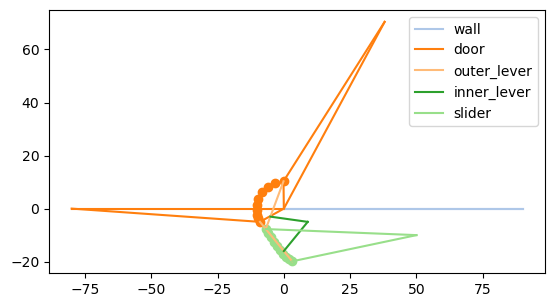

In [112]:
runner4 = Runner1D(model4, 
                      motion=motion4,
                      tracing_points=['door.1', 'slider.1'],
                      draw_model=draw_model,
                      draw_trace=draw_trace
                     )

runner4.run()

In [109]:
pd.DataFrame(runner3.trace)

,t,base.0,base.1,base.2,base.3,base.4,wall.0,wall.1,door.0,door.1,...,slider.1,slider.length,base0,base1,base2,door_console,outer_lever_spindle,outer_lever_end,base3,base4
0,79.002423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[0.0, 0.0]","[90.0, 0.0]","[0.0, 0.0]","[-25.0, -5.0]",...,"[5.8124, -48.1373]",79.002423,True,True,True,True,True,True,True,True
1,81.502423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, -0.0]","[-25.4893, -0.5421]",...,"[1.8574, -45.9556]",81.502423,True,True,True,True,True,True,True,True
2,84.002423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[0.0, 0.0]","[90.0, -0.0]","[-0.0, -0.0]","[-25.1149, 4.3867]",...,"[-2.0922, -43.3647]",84.002423,True,True,True,True,True,True,True,True
3,86.502423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, -0.0]","[-23.5996, 9.6468]",...,"[-6.0003, -40.3582]",86.502423,True,True,True,True,True,True,True,True
4,89.002423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, 0.0]","[-20.6494, 14.9533]",...,"[-9.8267, -36.9418]",89.002423,True,True,True,True,True,True,True,True
5,91.502423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, 0.0]","[-16.0225, 19.8313]",...,"[-13.5329, -33.1218]",91.502423,True,True,True,True,True,True,True,True
6,94.002423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, 0.0]","[-9.6176, 23.6115]",...,"[-17.0888, -28.871]",94.002423,True,True,True,True,True,True,True,True
7,96.502423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[-0.0, 0.0]","[-1.5264, 25.4494]",...,"[-20.4725, -24.061]",96.502423,True,True,True,True,True,True,True,True
8,99.002423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[-0.0, 0.0]","[90.0, -0.0]","[0.0, 0.0]","[7.9857, 24.2121]",...,"[-23.6519, -18.3236]",99.002423,True,True,True,True,True,True,True,True
9,101.502423,"[0, 0]","[90, 0]","[0, 0]","[25, -5]","[75, -10]","[0.0, -0.0]","[90.0, -0.0]","[0.0, -0.0]","[18.5063, 17.5362]",...,"[-26.5013, -10.4736]",101.502423,True,True,True,True,True,True,True,True


In [100]:
model4

Base 'base':
    point '0': [0 0] -> [0 0]
    point '1': [90  0] -> [90  0]
    point '2': [0 0] -> [0 0]
    point '3': [10. -5.] -> [10. -5.]
    point '4': [ 50. -10.] -> [ 50. -10.]
Solid 'wall': angle=[-0.  1.], v=[-0.  0.]
    point '0': [0 0] -> [-0.  0.]
    point '1': [90  0] -> [90. -0.]
Solid 'door': angle=[-0.9937  0.1124], v=[-0.  0.]
    point '0': [0 0] -> [-0.  0.]
    point '1': [-10.  -5.] -> [-6.0919  9.3749]
    point '2': [-80   0] -> [-8.9882 79.4935]
    point '3': [0 0] -> [-0.  0.]
Solid 'outer_lever': angle=[-0.609   0.7932], v=[4.8848 7.2505]
    point '0': [-10.  -5.] -> [-6.0919  9.3749]
    point '1': [  0. -16.] -> [-4.8596 -5.44  ]
    point '2': [  6.7267 -23.3994] -> [ -4.0306 -15.4056]
Solid 'inner_lever': angle=[-0.7197  0.6943], v=[6.6558 5.6685]
    point '0': [10. -5.] -> [10. -5.]
    point '1': [  0. -16.] -> [-4.8596 -5.44  ]
Slider 'slider': angle=[-0.1992  0.98  ], v=[2.9946 9.7608]
    point '0': [ 50. -10.] -> [ 50. -10.]
    point '1': [ 

In [ ]:
A = []